<hr>

## <h3 align="center"> EEIA 2024 -- Projet Résumé automatique de textes légaux <h3/>

<p>


Réalisé par : Dhalil BELLO et Vital GUINGUINNI

## Objectif du projet
L'objectif de ce projet est de résumer des sections de textes légaux à partir d'un modèle d'IA pré-entrainé.


## Données

Dataset open source de 446 sections de texte avec résumés


## Étapes du Notebook


1.   Installation et chargement des librairies
2.   Chargement, nettoyage et pré-processing des données
4.   Entrainement et sauvegarde du modèle

## 1.  Installation et chargement des librairies

In [76]:
#from google.colab import drive
#drive.mount('/content/drive')

In [77]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
import re
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from torch.utils.data import Dataset
import numpy as np

# 2. Chargement, nettoyage et pre-processing des données

In [78]:
# Chemins vers le jeu de données
open_source_path = '../data'
import os

filenames = [open_source_path + "/" + file for file in os.listdir(open_source_path) 
             if file.startswith("train_set_") and file.endswith(".json")]
filenames

['../data/train_set_helicopters.json', '../data/train_set_open_dataset.json']

In [79]:
# Fonction pour charger et formatter les données depuis un fichier JSON
def load_and_format_data(file_path):
    """Loads and formats data from a given JSON file into a list of dictionaries,
    where each dictionary represents an item with its unique ID and associated data."""
    with open(file_path, 'r') as file:
        data = json.load(file)
        formatted_data = [{'uid': key, **value} for key, value in data.items()]
    return formatted_data


# Fonction pour nettoyer les textes
def clean_text(text):
    """Cleans the given text by removing HTML tags, non-alphabetic characters,
    and extra spaces, then returns the cleaned text."""
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphabetic characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

In [80]:
# Chargement et formattage du jeu de données
df_helicopters = load_and_format_data(filenames[0]) 
df_helicopters = load_and_format_data(filenames[0])

# Conversion en Dataframe pour faciliter la manipulation
open_source_df_1 = pd.DataFrame(df_helicopters)[['uid','original_text','reference_summary']]
open_source_df_1

,uid,original_text,reference_summary
0,train_sum01,These general Standard Conditions of Sale appl...,These terms and conditions apply as soon as th...
1,train_sum010,Each Party represents to the other as at the d...,Each Party represents that the other is not a ...
2,train_sum0100,"All living, travelling and accommodation expen...","Expenses relating to the travelling, living an..."
3,train_sum0101,"Unless otherwise specified in the Contract, th...","Unless otherwise specified in the Contract, th..."
4,train_sum0102,Reasonable insurance coverage of risks arising...,Reasonable insurance coverage of risks arising...
...,...,...,...
408,train_sum095,No term or provision hereof will be considered...,"No term, provision or breach shall be waived o..."
409,train_sum096,Any variation or modification of the Contract ...,Any modification to the contract shall be put ...
410,train_sum097,The relationship between the Parties is solely...,No joint venture or partnership is intended no...
411,train_sum098,"The Customer shall not be entitled, without th...",Unless the Seller agrees to it through writing...


In [81]:
# Chargement et formattage du jeu de données
df_open = load_and_format_data(filenames[1]) 
df_open = load_and_format_data(filenames[1])

# Conversion en Dataframe pour faciliter la manipulation
open_source_df_2 = pd.DataFrame(df_open)[['uid','original_text','reference_summary']]
#open_source_df_2

In [82]:
open_source_df = pd.concat([open_source_df_1, open_source_df_2])
#open_source_df
open_source_df["len_original"] = open_source_df['original_text'].apply(lambda x : len(x))
open_source_df["len_sum"] = open_source_df["reference_summary"].apply(lambda x : len(x))
open_source_df['ratio'] = open_source_df["len_sum"] / open_source_df["len_original"]
open_source_df['verif'] = np.where((open_source_df["original_text"]==open_source_df["len_original"]),"idem", "bon")


open_source_df.verif.value_counts()

verif
bon    859
Name: count, dtype: int64

In [83]:
open_source_df = open_source_df[open_source_df['ratio']>0.05 ]
open_source_df = open_source_df[open_source_df['ratio']<1]
len(open_source_df)

809

In [84]:
# Nettoyage des textes
open_source_df['original_text_clean'] = open_source_df['original_text'].apply(clean_text)
open_source_df['reference_summary_clean'] = open_source_df['reference_summary'].apply(clean_text)

In [85]:
# Analyse de la longeur des textes originaux et des résumés associés
original_text_lengths = open_source_df['original_text_clean'].apply(len)
summary_lengths = open_source_df['reference_summary_clean'].apply(len)

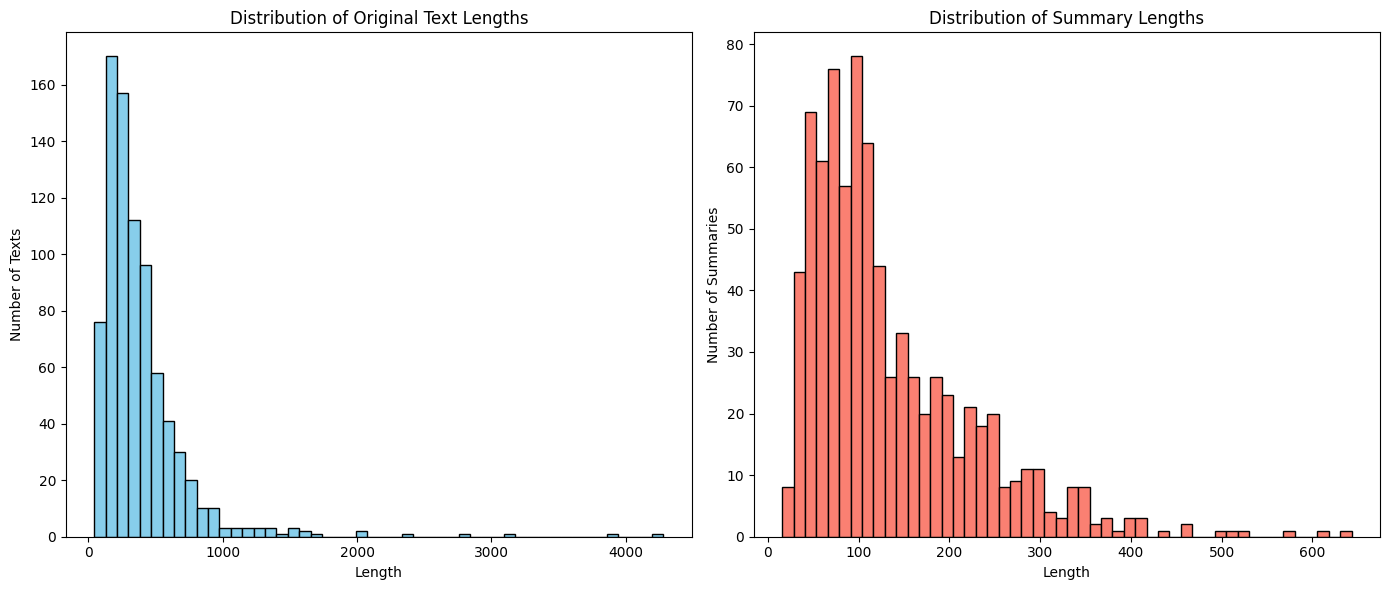

In [86]:
# Création de graphique pour la distribution des longueurs de textes
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(original_text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Original Text Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Texts')

plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=50, color='salmon', edgecolor='black')
plt.title('Distribution of Summary Lengths')
plt.xlabel('Length')
plt.ylabel('Number of Summaries')

plt.tight_layout()
plt.show()

# 3. Entrainement et sauvegarde du modèle

In [ ]:
# Initialisé le tokeniser et le modèle
tokenizer = AutoTokenizer.from_pretrained("sshleifer/distilbart-cnn-6-6")
model = AutoModelForSeq2SeqLM.from_pretrained("sshleifer/distilbart-cnn-6-6")

In [ ]:
# Data preprocessing function
def preprocess_data(df):
    """Tokenizes the texts and summaries in the dataframe using the BART tokenizer,
    then adds tokenized data as new columns for model training."""
    # Tokenize texts and summaries
    tokenized_data = tokenizer(df['original_text_clean'].tolist(), padding="max_length", truncation=True,
                               max_length=256, return_tensors="pt")
    tokenized_summaries = tokenizer(df['reference_summary_clean'].tolist(), padding="max_length", truncation=True,
                                    max_length=256, return_tensors="pt")

    # Convert tensors to lists for compatibility with pandas
    df['input_ids'] = tokenized_data['input_ids'].tolist()
    df['attention_mask'] = tokenized_data['attention_mask'].tolist()
    df['labels'] = tokenized_summaries['input_ids'].tolist()

    return df

In [ ]:
open_source_df = preprocess_data(open_source_df)

In [ ]:
# Diviser le jeu de données en training et test set
train_df, test_df = train_test_split(open_source_df, test_size=0.2, random_state=42)

In [ ]:
# Customisation du dataset pour l'entrainement
class SummaryDataset(Dataset):
    """A custom Dataset class for handling the tokenized text data for training and evaluation."""
    def __init__(self, df):
        self.input_ids = df['input_ids'].tolist()
        self.attention_mask = df['attention_mask'].tolist()
        self.labels = df['labels'].tolist()

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [ ]:
# Création des objets d'entrainement du dataset
train_dataset = SummaryDataset(train_df)
eval_dataset = SummaryDataset(test_df)

In [ ]:
!pip install transformers[torch]

In [ ]:
from transformers import Trainer, TrainingArguments

In [ ]:
# Configuration des paramètres d'entrainement
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=3,
    per_device_eval_batch_size=3,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

In [ ]:
# Initialisé et démarrer l'entrainement
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset
)

trainer.train()

Step,Training Loss
10,11.384700
20,10.887000
30,9.736000
40,8.801600
50,7.300500
60,5.232900
70,3.357300
80,2.150400
90,1.442800
100,1.044700


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

TrainOutput(global_step=1190, training_loss=0.5897783390301116, metrics={'train_runtime': 131.5913, 'train_samples_per_second': 27.053, 'train_steps_per_second': 9.043, 'total_flos': 964372746731520.0, 'train_loss': 0.5897783390301116, 'epoch': 10.0})

In [ ]:
# Sauvegarder le modèle entrainé et le tokeniser
model.save_pretrained('/content/drive/MyDrive/Resume/model_saved')
tokenizer.save_pretrained('/content/drive/MyDrive/Resume/model_saved')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


('/content/drive/MyDrive/Resume/model_saved/tokenizer_config.json',
 '/content/drive/MyDrive/Resume/model_saved/special_tokens_map.json',
 '/content/drive/MyDrive/Resume/model_saved/vocab.json',
 '/content/drive/MyDrive/Resume/model_saved/merges.txt',
 '/content/drive/MyDrive/Resume/model_saved/added_tokens.json',
 '/content/drive/MyDrive/Resume/model_saved/tokenizer.json')

In [19]:
num_cities = 10
cities = np.random.rand(num_cities, 2)

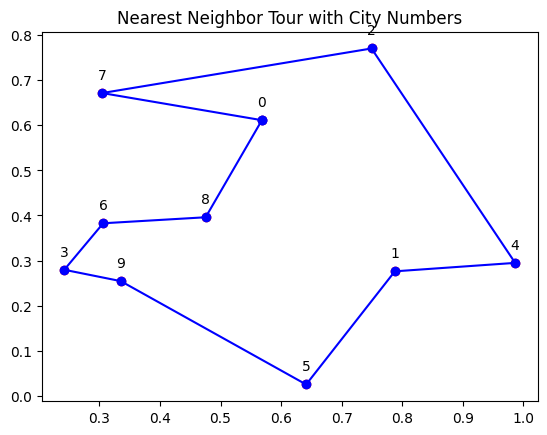

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Génération aléatoire des villes

def distance(city1, city2):
    return np.linalg.norm(city1 - city2)

def nearest_neighbor(cities):
    num_cities = len(cities)
    unvisited = list(range(num_cities))
    tour = [unvisited.pop(0)]

    while unvisited:
        last_visited = tour[-1]
        nearest = min(unvisited, key=lambda city: distance(cities[last_visited], cities[city]))
        tour.append(nearest)
        unvisited.remove(nearest)
    
    return tour

# Calcul du parcours
tour = nearest_neighbor(cities)

# Visualisation du parcours avec numéros des villes
def plot_tour(cities, tour):
    tour_cities = np.array([cities[i] for i in tour] + [cities[tour[0]]])
    plt.plot(tour_cities[:, 0], tour_cities[:, 1], 'bo-')
    
    for i, city in enumerate(tour):
        plt.annotate(str(city), (cities[city, 0], cities[city, 1]), textcoords="offset points", xytext=(0, 10), ha='center')
    
    plt.scatter(cities[:, 0], cities[:, 1], c='red')
    plt.title("Nearest Neighbor Tour with City Numbers")
    plt.show()

plot_tour(cities, tour)